In [34]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install tensorflow
%pip install scikit-learn
%pip install pandas-datareader
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
No

In [35]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

In [36]:
#------------------------------------------------------------------------------
# Load Data
## TO DO:
# 1) Check if data has been saved before.
# If so, load the saved data
# If not, save the data into a directory
#------------------------------------------------------------------------------

In [37]:
COMPANY = 'CBA.AX'
TRAIN_START = '2020-01-01' # Start date to read
TRAIN_END = '2023-08-01' # End date to read
DATA_DIR = 'stock_data'
import yfinance as yf

# Check if data has been saved before
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Create a file path for stock data
file_path = os.path.join(DATA_DIR, f'{COMPANY}_{TRAIN_START}_{TRAIN_END}.csv')

# Check if file exists
if os.path.exists(file_path):
    print(f"Loading data from {file_path}")
    # Load the data from the CSV file if it exists
    data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
else:
    print(f"Fetching data for {COMPANY} from Yahoo Finance")
    # Get the data for the stock AAPL
    data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
    # Saved the data to CSV
    data.to_csv(file_path)
    print(f"Data saved to {file_path}")

Loading data from stock_data/CBA.AX_2020-01-01_2023-08-01.csv


In [38]:
#------------------------------------------------------------------------------
# Prepare Data
## To do:
# 1) Use a different price value eg. mid-point of Open & Close
# 2) Change the Prediction days
#------------------------------------------------------------------------------

In [39]:
PRICE_VALUE = 'Mid_Price'
data[PRICE_VALUE] = (data['Open'] + data['Close']) / 2
scaler = MinMaxScaler(feature_range=(0, 1))
# Note that, by default, feature_range=(0, 1). Thus, if you want a different
# feature_range (min,max) then you'll need to specify it here
scaled_data = scaler.fit_transform(data[PRICE_VALUE].values.reshape(-1, 1))
# Flatten and normalise the data
# First, we reshape a 1D array(n) to 2D array(n,1)
# We have to do that because sklearn.preprocessing.fit_transform()
# requires a 2D array
# Here n == len(scaled_data)
# Then, we scale the whole array to the range (0,1)
# The parameter -1 allows (np.)reshape to figure out the array size n automatically
# values.reshape(-1, 1)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape'
# When reshaping an array, the new shape must contain the same number of elements
# as the old shape, meaning the products of the two shapes' dimensions must be equal.
# When using a -1, the dimension corresponding to the -1 will be the product of
# the dimensions of the original array divided by the product of the dimensions
# given to reshape so as to maintain the same number of elements.
# Number of days to look back to base the prediction
PREDICTION_DAYS = 30 # Original
# To store the training data
x_train = []
y_train = []
scaled_data = scaled_data[:,0] # Turn the 2D array back to a 1D array
# Prepare the data
for x in range(PREDICTION_DAYS, len(scaled_data)):
    x_train.append(scaled_data[x-PREDICTION_DAYS:x])
    y_train.append(scaled_data[x])
# Convert them into an array
x_train, y_train = np.array(x_train), np.array(y_train)
# Now, x_train is a 2D array(p,q) where p = len(scaled_data) - PREDICTION_DAYS
# and q = PREDICTION_DAYS; while y_train is a 1D array(p)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# We now reshape x_train into a 3D array(p, q, 1); Note that x_train
# is an array of p inputs with each input being a 2D array

In [40]:
#------------------------------------------------------------------------------
# Build the Model
## TO DO:
# 1) Check if data has been built before.
# If so, load the saved data
# If not, save the data into a directory
# 2) Change the model to increase accuracy?
#------------------------------------------------------------------------------

In [41]:

# TO DO:
# Save the model and reload it
# Sometimes, it takes a lot of effort to train your model (again, look at
# a training data with billions of input samples). Thus, after spending so
# much computing power to train your model, you may want to save it so that
# in the future, when you want to make the prediction, you only need to load
# your pre-trained model and run it on the new input for which the prediction
# need to be made.

In [42]:
from tensorflow.keras.models import load_model
MODEL_DIR = 'models'
MODEL_NAME = 'model_stock_price'

# Check if data has been saved before
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Define model file path
model_file_path = os.path.join(MODEL_DIR, f'{MODEL_NAME}.h5')

# Check if the model file exists
if os.path.exists(model_file_path):
    print(f"Loading model from {model_file_path}")
    # Load the model from the file if it exists
    model = load_model(model_file_path)
else:
    print(f"Training new model and saving to {model_file_path}")
    # Create a simple Sequential model (you can customise the architecture)
    model = Sequential() # Basic neural network
    # See: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
    # for some useful examples
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # This is our first hidden layer which also spcifies an input layer.
    # That's why we specify the input shape for this layer;
    # i.e. the format of each training example
    # The above would be equivalent to the following two lines of code:
    # model.add(InputLayer(input_shape=(x_train.shape[1], 1)))
    # model.add(LSTM(units=50, return_sequences=True))
    # For som eadvances explanation of return_sequences:
    # https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
    # https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/
    # As explained there, for a stacked LSTM, you must set return_sequences=True
    # when stacking LSTM layers so that the next LSTM layer has a
    # three-dimensional sequence input.
    # Finally, units specifies the number of nodes in this layer.
    # This is one of the parameters you want to play with to see what number
    # of units will give you better prediction quality (for your problem)
    model.add(Dropout(0.2))
    # The Dropout layer randomly sets input units to 0 with a frequency of
    # rate (= 0.2 above) at each step during training time, which helps
    # prevent overfitting (one of the major problems of ML).
    model.add(LSTM(units=50, return_sequences=True))
    # More on Stacked LSTM:
    # https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Prediction of the next closing value of the stock price
    # We compile the model by specify the parameters for the model
    # See lecture Week 6 (COS30018)
    model.compile(optimizer='adam', loss='mean_squared_error')
    # The optimizer and loss are two important parameters when building an
    # ANN model. Choosing a different optimizer/loss can affect the prediction
    # quality significantly. You should try other settings to learn; e.g.
    # optimizer='rmsprop'/'sgd'/'adadelta'/...
    # loss='mean_absolute_error'/'huber_loss'/'cosine_similarity'/...
    # Now we are going to train this model with our training data
    # (x_train, y_train)
    model.fit(x_train, y_train, epochs=25, batch_size=32)
    # Other parameters to consider: How many rounds(epochs) are we going to
    # train our model? Typically, the more the better, but be careful about
    # overfitting!
    # What about batch_size? Well, again, please refer to
    # Lecture Week 6 (COS30018): If you update your model for each and every
    # input sample, then there are potentially 2 issues: 1. If you training
    # data is very big (billions of input samples) then it will take VERY long;
    # 2. Each and every input can immediately makes changes to your model
    # (a souce of overfitting). Thus, we do this in batches: We'll look at
    # the aggreated errors/losses from a batch of, say, 32 input samples
    # and update our model based on this aggregated loss.
    model.save(model_file_path) # Saves in Tensorflow Savedmodel Format
    print(f"Model saved to {model_file_path}")

Loading model from models/model_stock_price.h5


In [43]:
#------------------------------------------------------------------------------
# Test the model accuracy on existing data
#------------------------------------------------------------------------------

In [44]:
# Load the test data
TEST_START = '2023-08-02'
TEST_END = '2024-07-02'
# test_data = web.DataReader(COMPANY, DATA_SOURCE, TEST_START, TEST_END)
test_data = yf.download(COMPANY,TEST_START,TEST_END)
# The above bug is the reason for the following line of code

test_data[PRICE_VALUE] = (test_data['Open'] + test_data['Close']) / 2

actual_prices = test_data[PRICE_VALUE].values
total_dataset = pd.concat((data[PRICE_VALUE], test_data[PRICE_VALUE]), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) -
PREDICTION_DAYS:].values
# We need to do the above because to predict the closing price of the fisrt
# PREDICTION_DAYS of the test period [TEST_START, TEST_END], we'll need the
# data from the training period
model_inputs = model_inputs.reshape(-1, 1)
# TO DO: Explain the above line
# scaled_data = scaler.fit_transform(data[PRICE_VALUE].values.reshape(-1, 1))
# Flatten and normalise the data
# First, we reshape a 1D array(n) to 2D array(n,1)
# Then, we scale the whole array to the range (0,1)
# The parameter -1 allows (np.)reshape to figure out the array size n automatically
# values.reshape(-1, 1)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape'
# When reshaping an array, the new shape must contain the same number of elements as the old shape, meaning the products of the two shapes' dimensions must be equal.
# When using a -1, the dimension corresponding to the -1 will be the product of the dimensions of the original array divided by the product of the dimensions given to reshape so as to maintain the same number of elements.
model_inputs = scaler.transform(model_inputs)
# We again normalize our closing price data to fit them into the range (0,1)
# using the same scaler used above
# However, there may be a problem: scaler was computed on the basis of
# the Max/Min of the stock price for the period [TRAIN_START, TRAIN_END],
# but there may be a lower/higher price during the test period
# [TEST_START, TEST_END]. That can lead to out-of-bound values (negative and
# greater than one)
# We'll call this ISSUE #2
# TO DO: Generally, there is a better way to process the data so that we
# can use part of it for training and the rest for testing. You need to
# implement such a way

[*********************100%%**********************]  1 of 1 completed


In [45]:
#------------------------------------------------------------------------------
# Make predictions on test data
#------------------------------------------------------------------------------

In [46]:
x_test = []
for x in range(PREDICTION_DAYS, len(model_inputs)):
    x_test.append(model_inputs[x - PREDICTION_DAYS:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# TO DO: Explain the above 5 lines
# creating an empty sequences for x_test for prediction days ranged from prediction days to the end, in each iteration, the x_test append the sequence of array in model_inputs from iteration minus prediction days to current index x
# apply numpy array at x_test and reshape at 3D array
# By creating the array at x_test, we need to make a window slicing 
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Clearly, as we transform our data into the normalized range (0,1),
# we now need to reverse this transformation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [47]:
#------------------------------------------------------------------------------
# Plot the test predictions
## To do:
# 1) Candle stick charts
# 2) Chart showing High & Lows of the day
# 3) Show chart of next few days (predicted)
#------------------------------------------------------------------------------

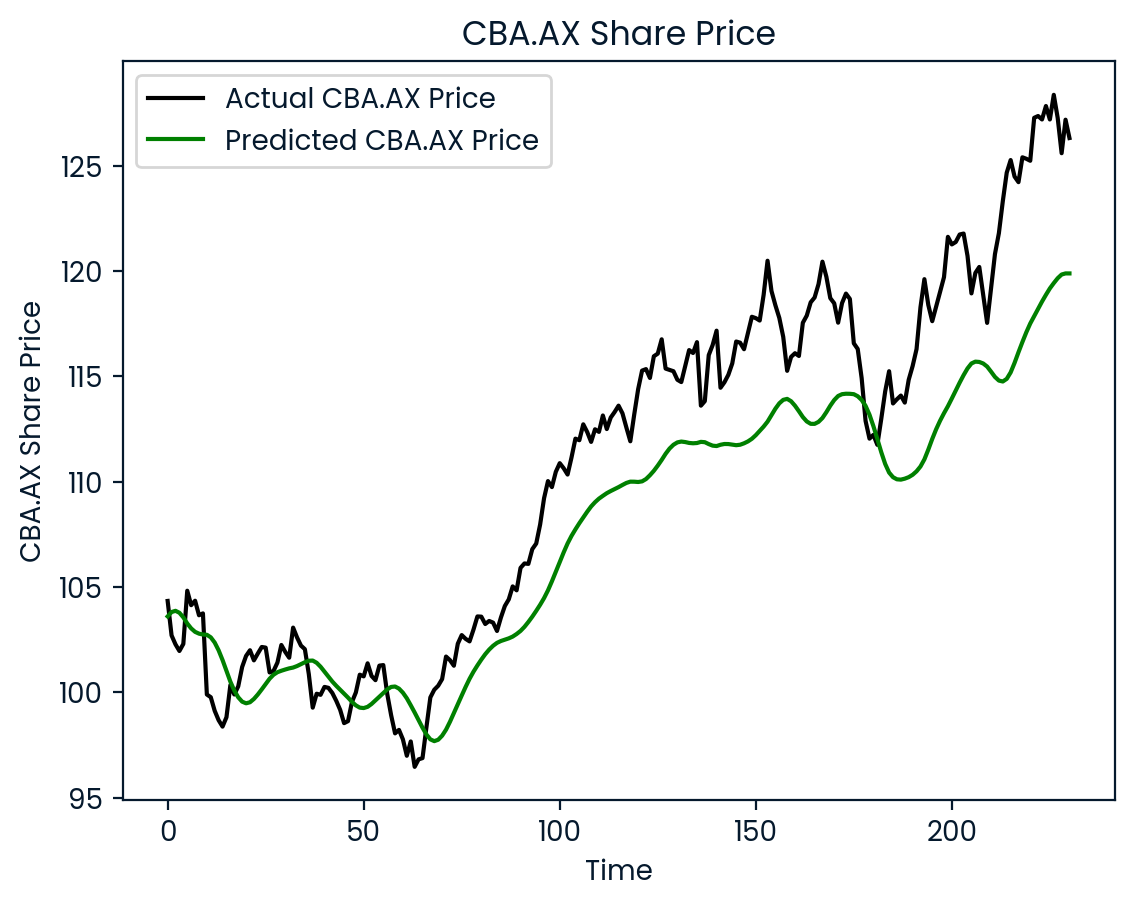

In [48]:
plt.plot(actual_prices, color="black", label=f"Actual {COMPANY} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {COMPANY} Price")
plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()

In [49]:
#------------------------------------------------------------------------------
# Predict next day
#------------------------------------------------------------------------------

In [50]:
real_data = [model_inputs[len(model_inputs) - PREDICTION_DAYS:, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: [[119.83435]]


In [51]:
# A few concluding remarks here:
# 1. The predictor is quite bad, especially if you look at the next day
# prediction, it missed the actual price by about 10%-13%
# Can you find the reason
# Lack of data points, only single input feature, and only mid-point price does not capture the best
# Simple LSTM model without complexity and not LSTM will work well with dataset, might comparsion with other model name such as GRU, RNN.
# 2. The code base at
# https://github.com/x4nth055/pythoncode-tutorials/tree/master/machine-learning/stock-prediction
# gives a much better prediction. Even though on the surface, it didn't seem
# to be a big difference (both use Stacked LSTM)
# Again, can you explain it?
# LSTM will perform the best whether large dataset. 
# A more advanced and quite different technique use CNN to analyse the images
# of the stock price changes to detect some patterns with the trend of
# the stock price:
# https://github.com/jason887/Using-Deep-Learning-Neural-Networks-and-Candlestick-Chart-Representation-to-Predict-Stock-Market
# Can you combine these different techniques for a better prediction??